##### Copyright 2018 The TensorFlow Authors.

In [61]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [62]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [63]:
# Use seaborn for pairplot.
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [65]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.16.1


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [94]:
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv('auto-mpg.data', names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

raw_dataset = pd.read_csv("neospectra_db/Neospectra_WoodwellKSSL_avg_soil+site+NIR.csv")

/tmp/ipykernel_151351/3117379959.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dataset = pd.read_csv("neospectra_db/Neospectra_WoodwellKSSL_avg_soil+site+NIR.csv")


In [95]:
dataset = raw_dataset.copy()
dataset.tail()

,kssl_id,lay_id,Lab,WOODWELL_ID,Lab_ID,country,scanner_name,scanner_SerialNo,saucer,lay.type,...,1372.710602,1370.149576,1367.598087,1365.056084,1362.523513,1360.000322,1357.486459,1354.981872,1352.48651,1350.000323
8090,278980,191247,KSSL,NaN,NEO9_278980,United States,NEO9,22030076,y,horizon,...,55.911526,55.923274,55.929868,55.921488,55.887531,55.825651,55.746030,55.667427,55.607023,55.570222
8091,278985,191252,KSSL,NaN,NEO9_278985,United States,NEO9,22030076,y,horizon,...,50.434422,50.422152,50.434359,50.462291,50.476740,50.456403,50.401207,50.332342,50.278105,50.254896
8092,278990,191257,KSSL,NaN,NEO9_278990,United States,NEO9,22030076,y,horizon,...,48.975273,48.964194,48.945535,48.897872,48.808953,48.684554,48.548499,48.432039,48.357548,48.326151
8093,278991,191258,KSSL,NaN,NEO9_278991,United States,NEO9,22030076,y,horizon,...,41.196096,41.137551,41.077202,41.021650,40.967597,40.911748,40.856572,40.810147,40.780178,40.766655
8094,278995,191262,KSSL,NaN,NEO9_278995,United States,NEO9,22030076,y,horizon,...,41.482242,41.474521,41.461230,41.431987,41.377310,41.297246,41.204329,41.118617,41.057123,41.024107


### Clean the data

The dataset contains a few unknown values:

In [96]:
dataset.isna().sum()

kssl_id           0
lay_id            0
Lab               0
WOODWELL_ID    4981
Lab_ID            0
               ... 
1360.000322       0
1357.486459       0
1354.981872       0
1352.48651        0
1350.000323       0
Length: 312, dtype: int64

Drop those rows to keep this initial tutorial simple:

In [91]:
# dataset = dataset.dropna()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [97]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

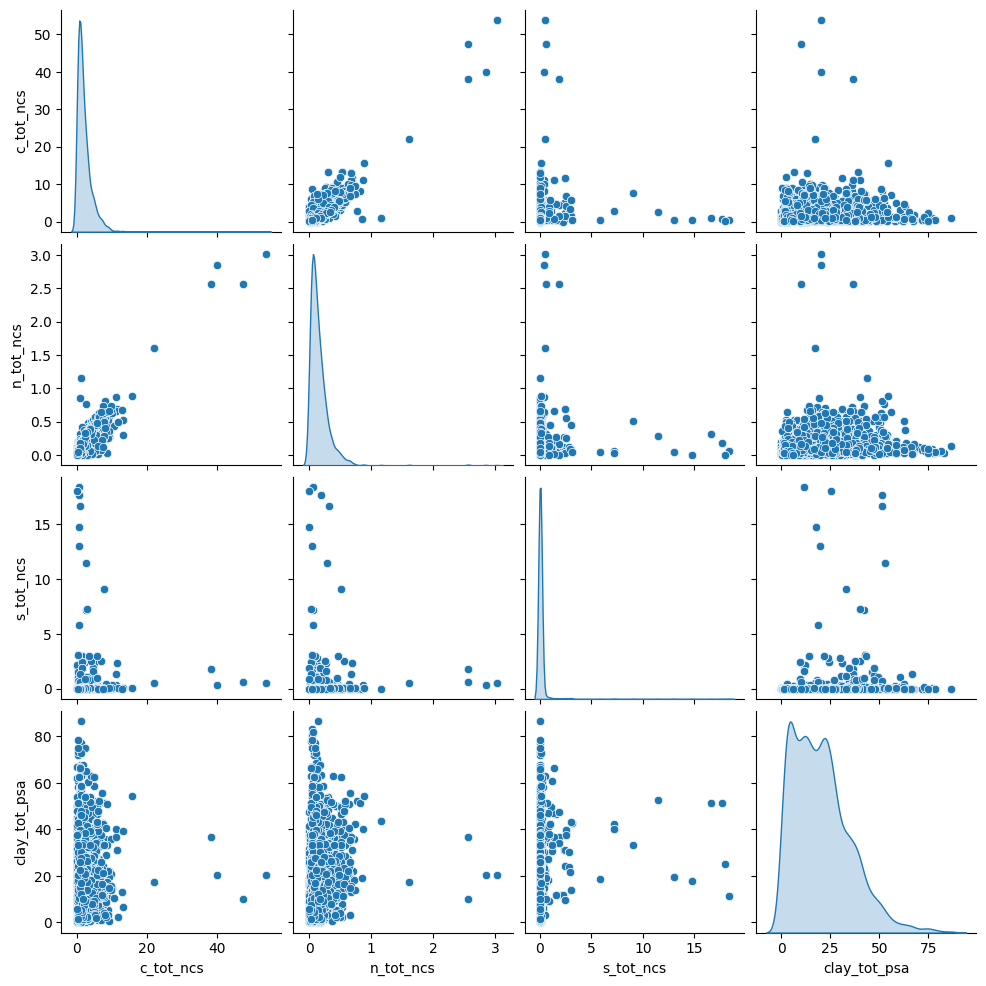

In [98]:
sns.pairplot(train_dataset[['c_tot_ncs', 'n_tot_ncs', 's_tot_ncs', 'clay_tot_psa']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [99]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
kssl_id,6476.0,1.395944e+05,64684.043457,2.694900e+04,9.556600e+04,1.210000e+05,1.792380e+05,2.789950e+05
lay_id,6476.0,7.078539e+04,55519.507368,7.980000e+02,3.581300e+04,4.771200e+04,8.161100e+04,1.912620e+05
scanner_SerialNo,6476.0,2.127400e+07,435056.591338,2.102003e+07,2.102007e+07,2.102008e+07,2.106004e+07,2.203008e+07
proj.id,6332.0,3.848030e+03,933.436865,1.210000e+02,3.594000e+03,3.924000e+03,4.468000e+03,5.192000e+03
lims.site.id,6332.0,1.500198e+04,8199.640724,7.950000e+02,1.002500e+04,1.190800e+04,1.939800e+04,3.234300e+04
...,...,...,...,...,...,...,...,...
1360.000322,6476.0,4.574985e+01,11.953604,9.052126e+00,3.715924e+01,4.532659e+01,5.376840e+01,9.500336e+01
1357.486459,6476.0,4.571015e+01,11.956687,9.050155e+00,3.709556e+01,4.528748e+01,5.373913e+01,9.531013e+01
1354.981872,6476.0,4.566153e+01,11.961282,9.027407e+00,3.703098e+01,4.521639e+01,5.370852e+01,9.583374e+01
1352.48651,6476.0,4.560697e+01,11.967359,8.989000e+00,3.698654e+01,4.513299e+01,5.361916e+01,9.642330e+01


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [102]:
train_features = train_dataset.copy().iloc[:,55:]
test_features = test_dataset.copy().iloc[:,55:]

train_labels = train_dataset.copy()['eoc_tot_c']
test_labels = test_dataset.copy()['eoc_tot_c']

print(train_features.head())
print(train_labels.head())

      2549.999982  2541.176458  2532.413785  2523.711336  2515.068494  \
2568    44.795381    45.480159    46.005993    46.488779    47.060889   
7275    42.571189    42.791426    42.906464    42.997152    43.152230   
1564    25.711121    25.931249    26.128342    26.294386    26.459970   
3253    73.095483    72.877410    72.899332    73.041139    73.200820   
3526    63.175397    63.438961    63.732421    63.995435    64.231526   

      2506.484647  2497.959193  2489.491539  2481.081099  2472.727295  ...  \
2568    47.790659    48.642393    49.487977    50.200771    50.754143  ...   
7275    43.421399    43.794739    44.220031    44.645402    45.060506  ...   
1564    26.670090    26.960893    27.325278    27.730827    28.137965  ...   
3253    73.325951    73.420722    73.526096    73.687748    73.932598  ...   
3526    64.488038    64.817043    65.240101    65.735421    66.253618  ...   

      1372.710602  1370.149576  1367.598087  1365.056084  1362.523513  \
2568    69.878352  

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [103]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
kssl_id,1.395944e+05,64684.043457
lay_id,7.078539e+04,55519.507368
scanner_SerialNo,2.127400e+07,435056.591338
proj.id,3.848030e+03,933.436865
lims.site.id,1.500198e+04,8199.640724
...,...,...
1360.000322,4.574985e+01,11.953604
1357.486459,4.571015e+01,11.956687
1354.981872,4.566153e+01,11.961282
1352.48651,4.560697e+01,11.967359


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [104]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [105]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [106]:
print(normalizer.mean.numpy())

[[41.024 41.117 41.236 41.38  41.559 41.785 42.065 42.391 42.748 43.123
  43.512 43.922 44.368 44.859 45.385 45.922 46.431 46.878 47.247 47.546
  47.8   48.043 48.299 48.576 48.872 49.184 49.513 49.868 50.26  50.687
  51.13  51.558 51.937 52.25  52.505 52.727 52.94  53.149 53.32  53.398
  53.326 53.087 52.718 52.317 52.017 51.93  52.117 52.556 53.16  53.817
  54.426 54.93  55.326 55.643 55.923 56.19  56.44  56.647 56.783 56.84
  56.833 56.8   56.778 56.788 56.827 56.868 56.88  56.84  56.744 56.612
  56.472 56.347 56.241 56.137 56.006 55.817 55.559 55.24  54.886 54.526
  54.183 53.858 53.537 53.195 52.818 52.41  52.    51.621 51.291 50.999
  50.697 50.329 49.858 49.305 48.768 48.408 48.41  48.915 49.948 51.393
  53.042 54.655 56.034 57.069 57.748 58.14  58.351 58.476 58.572 58.652
  58.701 58.696 58.636 58.539 58.435 58.348 58.283 58.229 58.166 58.08
  57.97  57.849 57.735 57.641 57.565 57.497 57.423 57.333 57.231 57.126
  57.028 56.943 56.866 56.787 56.696 56.59  56.475 56.363 56.264 5

When the layer is called, it returns the input data, with each feature independently normalized:

In [107]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[44.8  45.48 46.01 46.49 47.06 47.79 48.64 49.49 50.2  50.75 51.24 51.83
  52.64 53.72 54.92 56.02 56.8  57.18 57.24 57.23 57.43 58.   58.91 59.97
  60.97 61.75 62.34 62.88 63.54 64.43 65.51 66.62 67.56 68.25 68.8  69.39
  70.16 71.09 71.92 72.22 71.62 70.   67.57 64.9  62.67 61.49 61.59 62.71
  64.37 66.09 67.59 68.86 70.13 71.65 73.57 75.76 77.93 79.69 80.75 81.11
  81.04 80.9  80.97 81.34 81.91 82.45 82.76 82.77 82.54 82.25 82.07 82.08
  82.19 82.25 82.13 81.78 81.27 80.73 80.29 79.98 79.78 79.56 79.21 78.7
  78.06 77.43 76.92 76.59 76.37 76.13 75.73 75.07 74.16 73.16 72.28 71.79
  71.89 72.7  74.14 76.   78.03 80.02 81.79 83.27 84.42 85.27 85.85 86.21
  86.4  86.47 86.44 86.38 86.32 86.28 86.28 86.3  86.3  86.28 86.22 86.13
  86.04 85.97 85.93 85.92 85.92 85.9  85.87 85.83 85.78 85.75 85.72 85.68
  85.63 85.54 85.42 85.3  85.2  85.11 85.05 84.97 84.87 84.72 84.55 84.38
  84.23 84.1  83.99 83.87 83.72 83.53 83.33 83.14 82.98 82.85 82.73 82.59
  82.42 82.23 82.05 81.9

## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

This model will predict `'MPG'` from `'Horsepower'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

Visualize the model's training progress using the stats stored in the `history` object:

Collect the results on the test set for later:

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $x$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [108]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [109]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[ 2.921],
       [ 2.555],
       [-1.769],
       [ 2.634],
       [ 2.85 ],
       [ 0.553],
       [-1.476],
       [ 1.359],
       [ 1.326],
       [-0.922]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [110]:
linear_model.layers[1].kernel

<KerasVariable shape=(257, 1), dtype=float32, path=sequential_8/dense_18/kernel>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

Epoch 1/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.9535 - val_loss: 0.9892
Epoch 2/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.8901 - val_loss: 0.9167
Epoch 3/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.8735 - val_loss: 0.9141
Epoch 4/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 0.9396 - val_loss: 1.0035
Epoch 5/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.9538 - val_loss: 0.9535
Epoch 6/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.9661 - val_loss: 0.9216
Epoch 7/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.9625 - val_loss: 0.9193
Epoch 8/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 0.9161 - val_loss: 0.9307
Epoch 9/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.9238 - val_loss: 0.9326
Epoch 10/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.9509 - val_loss: 0.9793
Epoch 11/500
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.9525 - val_loss: 1.1040
Epoch 12/500
162/16

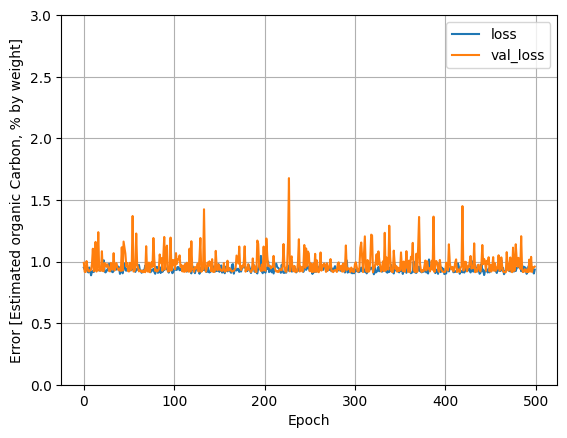

In [131]:
%%time

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=500,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Estimated organic Carbon, % by weight]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

Collect the results on the test set for later:

In [132]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [139]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [140]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 257)            │           515 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515 (2.02 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 515 (2.02 KB)

Epoch 1/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5911 - val_loss: 1.2512
Epoch 2/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 1.2545 - val_loss: 1.1459
Epoch 3/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 1.1488 - val_loss: 1.1085
Epoch 4/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.0453 - val_loss: 1.0620
Epoch 5/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.9984 - val_loss: 1.0823
Epoch 6/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 1.0069 - val_loss: 1.1276
Epoch 7/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.9314 - val_loss: 0.9396
Epoch 8/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.9156 - val_loss: 0.9413
Epoch 9/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.9262 - val_loss: 0.9449
Epoch 10/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.8888 - val_loss: 0.9277
Epoch 11/3000
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.9249 - val_loss: 0.9652
Epoch 12/3

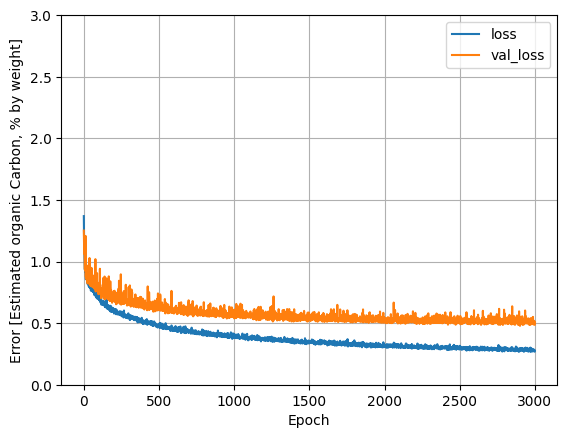

In [141]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=3000)

plot_loss(history)

Collect the results on the test set:

In [142]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [151]:
pd.DataFrame(test_results, index=['Mean absolute error [EOC by % weight]']).T

,Mean absolute error [EOC by % weight]
linear_model,0.962792
dnn_model,0.507567


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


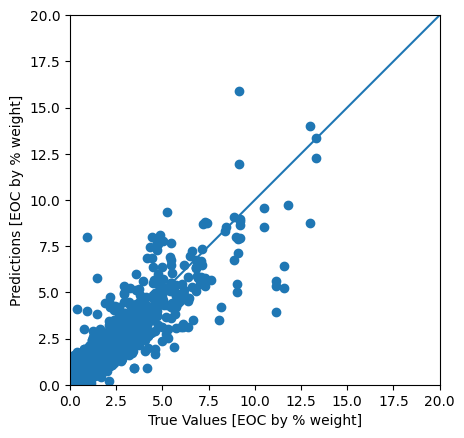

In [152]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [EOC by % weight]')
plt.ylabel('Predictions [EOC by % weight]')
lims = [-0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [160]:
metric = keras.metrics.R2Score()
metric.update_state(test_labels.values.reshape((-1,1)), test_predictions.reshape((-1,1)))
result = metric.result()
print(result)

tf.Tensor(0.85567784, shape=(), dtype=float32)


It appears that the model predicts reasonably well.

Now, check the error distribution:

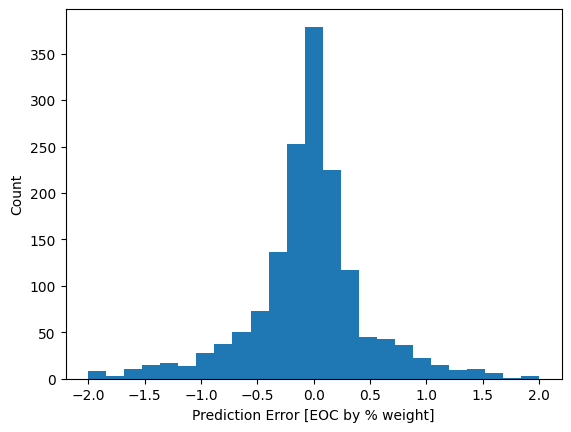

In [153]:
error = test_predictions - test_labels
plt.hist(error, bins=25, range=(-2,2))
plt.xlabel('Prediction Error [EOC by % weight]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [154]:
dnn_model.save('dnn_model.keras')

If you reload the model, it gives identical output:

In [155]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [156]:
pd.DataFrame(test_results, index=['Mean absolute error [EOC by % weight]']).T

,Mean absolute error [EOC by % weight]
linear_model,0.962792
dnn_model,0.507567
reloaded,0.507567


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.